In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os
import urllib.request
import zipfile
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from PIL import Image
import io
import ipywidgets as widgets
from IPython.display import display

2024-06-05 01:56:11.707779: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 01:56:11.707926: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 01:56:11.841330: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
url = 'https://github.com/dekwannn/wastemanagement/archive/refs/heads/main.zip'
zip_path = 'dataset-resized.zip'
extract_path = 'dataset-resized'

# Download the dataset zip file
urllib.request.urlretrieve(url, zip_path)

# Unzip the downloaded file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Define the new data directory after extraction
data_dir = os.path.join(extract_path, 'wastemanagement-main/ML/backup_data/dataset-resized')

In [ ]:
# Create a list of filepaths and labels
filepaths = []
labels = []
classlist = os.listdir(data_dir)
for kelass in classlist:
    classpath = os.path.join(data_dir, kelass)
    if os.path.isdir(classpath):
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(kelass)

# Create a DataFrame
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

print(df.head())
print(df['labels'].value_counts())

                                           filepaths     labels
0  dataset-resized/wastemanagement-main/ML/backup...  cardboard
1  dataset-resized/wastemanagement-main/ML/backup...  cardboard
2  dataset-resized/wastemanagement-main/ML/backup...  cardboard
3  dataset-resized/wastemanagement-main/ML/backup...  cardboard
4  dataset-resized/wastemanagement-main/ML/backup...  cardboard
labels
glass          1905
shoes          1665
paper          1644
non_recycle    1644
clothes        1626
plastic        1542
metal          1399
cardboard      1294
battery         945
Name: count, dtype: int64


In [ ]:
# Splitting data into train, validation, and test sets
train_split = .8
test_split = .1
dummy_split = test_split / (1 - train_split)
train_df, dummy_df = train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df = train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print('train_df length:', len(train_df), 'test_df length:', len(test_df), 'valid_df length:', len(valid_df))


train_df length: 10931 test_df length: 1366 valid_df length: 1367


In [ ]:
# Preprocessing dataset
height = 224
width = 224
channels = 3
batch_size = 64
img_shape = (height, width, channels)
img_size = (height, width)

length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1, length+1) if length % n == 0 and length/n <= 80], reverse=True)[0]
test_steps = int(length/test_batch_size)
print('test batch size:', test_batch_size, 'test steps:', test_steps)

test batch size: 2 test steps: 683


In [ ]:
#augmentation
gen = ImageDataGenerator(rescale=1./255, rotation_range=15, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
train_gen = gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
validgen = ImageDataGenerator(rescale=1./255)
valid_gen = validgen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
testgen = ImageDataGenerator(rescale=1./255)
test_gen = testgen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
classes = list(train_gen.class_indices.keys())
print(classes)
class_count = len(classes)

Found 10931 validated image filenames belonging to 9 classes.
Found 1367 validated image filenames belonging to 9 classes.
Found 1366 validated image filenames belonging to 9 classes.
['battery', 'cardboard', 'clothes', 'glass', 'metal', 'non_recycle', 'paper', 'plastic', 'shoes']


In [ ]:
# Image augmentation
gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
#buat generator untuk train, valid, test
train_gen = gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                    target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
validgen = ImageDataGenerator(rescale=1./255)
valid_gen = validgen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                         target_size=img_size, class_mode='categorical',
                                         color_mode='rgb', shuffle=True, batch_size=batch_size)
testgen = ImageDataGenerator(rescale=1./255)
test_gen = testgen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=False, batch_size=test_batch_size)

Found 10931 validated image filenames belonging to 9 classes.
Found 1367 validated image filenames belonging to 9 classes.
Found 1366 validated image filenames belonging to 9 classes.


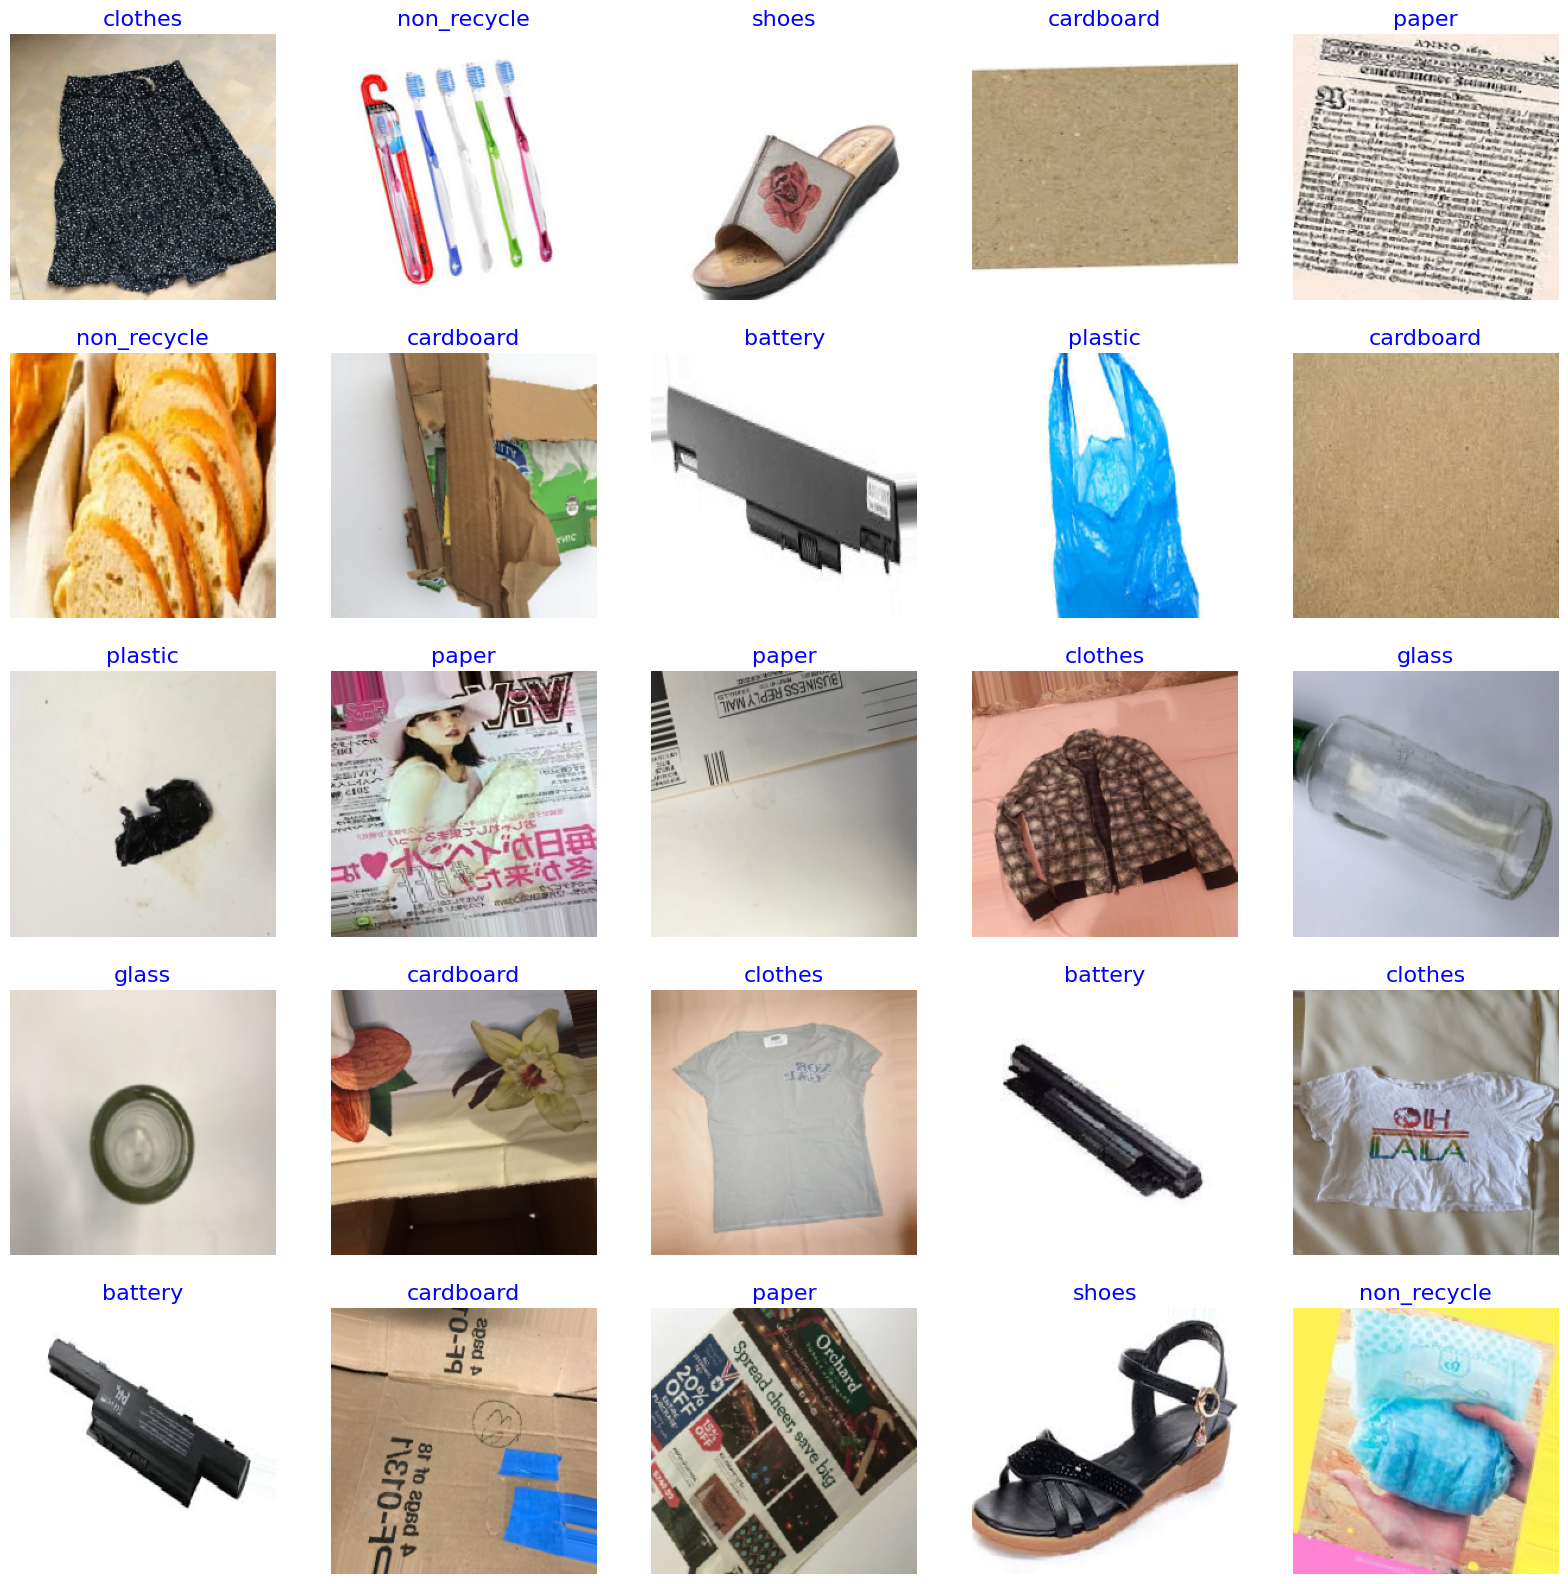

In [ ]:
# Visualizing some sample images
def show_image_samples(gen):
    images, labels = next(gen)
    plt.figure(figsize=(20, 20))
    for i in range(min(len(labels), 25)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen)

In [ ]:
# Definisiin extractor dan compile model
base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = False
extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('block_15_project_BN').output)

# Build the model
model = Sequential([
    extractor,  # Feature extractor
    Conv2D(filters=32, padding='same', kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=2, strides=2),
    Conv2D(filters=64, padding='same', kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=2, strides=2),
    Dropout(rate=0.5),
    Flatten(),
    Dense(len(classes), activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Call build() method to build the model
model.build((None, 224, 224, 3))

# Print model summary
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_1 (Functional)       │ (None, 7, 7, 160)      │     1,364,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 32)       │        46,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,430,057 (5.46 MB)

 Trainable params: 65,193 (254.66 KB)

 Non-trainable params: 1,364,864 (5.21 MB)

In [ ]:
# Training the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

history = model.fit(train_gen, epochs=20, validation_data=valid_gen, callbacks=[early_stopping, checkpoint])

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/171 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.0898 - loss: 5.9772   

I0000 00:00:1717552736.256241     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


171/171 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.3540 - loss: 2.2064 - val_accuracy: 0.7242 - val_loss: 0.8386
Epoch 2/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 168s 943ms/step - accuracy: 0.6711 - loss: 0.9494 - val_accuracy: 0.7623 - val_loss: 0.6792
Epoch 3/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 171s 958ms/step - accuracy: 0.7432 - loss: 0.7430 - val_accuracy: 0.7959 - val_loss: 0.6325
Epoch 4/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 171s 963ms/step - accuracy: 0.7739 - loss: 0.6707 - val_accuracy: 0.8105 - val_loss: 0.5539
Epoch 5/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 170s 955ms/step - accuracy: 0.8004 - loss: 0.5934 - val_accuracy: 0.8303 - val_loss: 0.5170
Epoch 6/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 173s 967ms/step - accuracy: 0.8109 - loss: 0.5500 - val_accuracy: 0.8456 - val_loss: 0.5039
Epoch 7/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 168s 944ms/step - accuracy: 0.8340 - loss: 0.5161 - val_accuracy: 0.8493 - val_loss: 0.4966
Epoch 8/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 170s 952ms/step - accuracy: 0.8339 - loss: 0.4893 

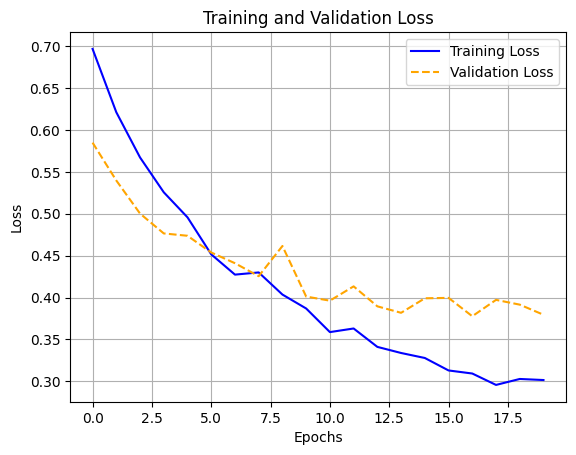

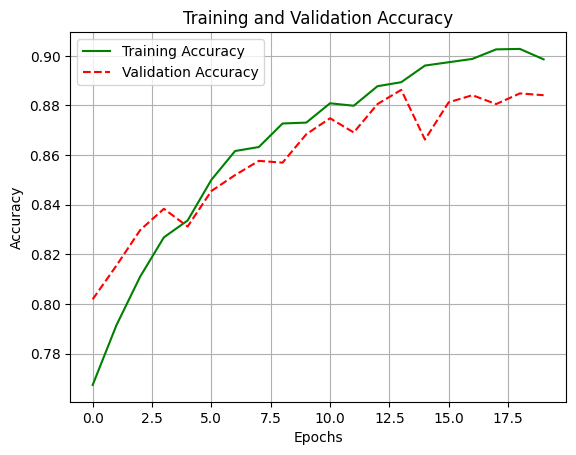

In [ ]:
# # Plot training and validation loss
# plt.plot(history.history['loss'], label='Training Loss', color='blue', linestyle='-')
# plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot training and validation accuracy
# plt.plot(history.history['accuracy'], label='Training Accuracy', color='green', linestyle='-')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)
# plt.show()


In [ ]:
# # Save the trained model as HDF5 file
# model.save('my_model.keras')

In [ ]:
# # Convert the model to TFLite format
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the TFLite model to a file
# with open('model.tflite', 'wb') as f:
#     f.write(tflite_model)

In [ ]:
# from tensorflow.keras.preprocessing import image


# # Define the classes
# classes = ["BATTERY", "BIOLOGICAL", "CLOTHES", "CARDBOARD", "GLASS", "METAL", "PAPER", "PLASTIC", "NON_RECYCLE","SHOES" ]


In [ ]:
# # Function to preprocess the image
# def preprocess_image(img, img_size=(224, 224)):
#     img = img.resize(img_size)
#     img_array = image.img_to_array(img)
#     img_array = np.expand_dims(img_array, axis=0)  # Create a batch
#     img_array = img_array / 255.0  # Rescale image
#     return img_array

In [ ]:
# # Function to predict the class of the image
# def predict_image_class(model, img):
#     img_array = preprocess_image(img)
#     predictions = model.predict(img_array)
#     predicted_class = np.argmax(predictions, axis=1)
#     class_name = classes[predicted_class[0]]
#     confidence = np.max(predictions) * 100
#     return class_name, confidence

In [ ]:
# # Function to display the image with predicted class and confidence
# def display_prediction(img, class_name, confidence):
#     plt.imshow(img)
#     plt.title(f"Predicted: {class_name} ({confidence:.2f}%)")
#     plt.axis('off')
#     plt.show()

In [ ]:
# # Create a file upload widget
# upload_widget = widgets.FileUpload(accept='image/*', multiple=False)

# def on_upload_change(change):
#     # Get the uploaded file
#     file = next(iter(upload_widget.value.values()))
#     content = file['content']

#     # Open the image
#     img = Image.open(io.BytesIO(content))

#     # Predict the class of the image
#     class_name, confidence = predict_image_class(model, img)

#     # Display the image and prediction
#     display_prediction(img, class_name, confidence)

FileUpload(value={}, accept='image/*', description='Upload')

1/1 [==============================] - 0s 25ms/step


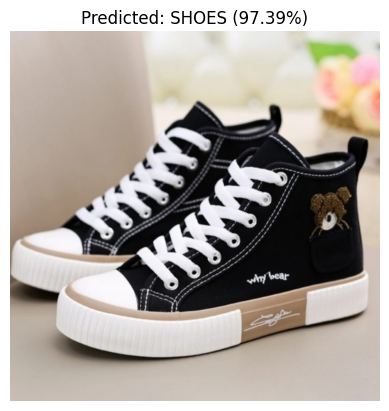

1/1 [==============================] - 0s 23ms/step


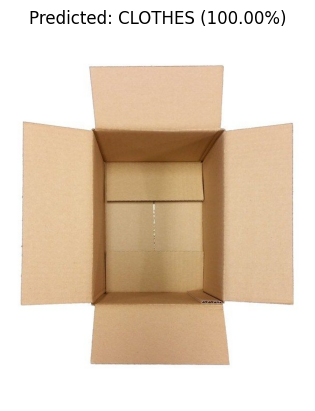

1/1 [==============================] - 0s 23ms/step


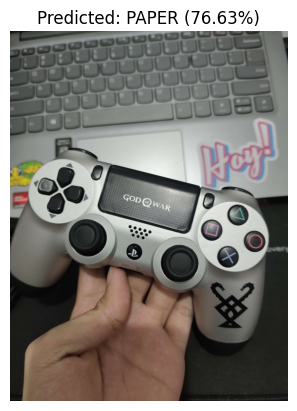

1/1 [==============================] - 0s 24ms/step


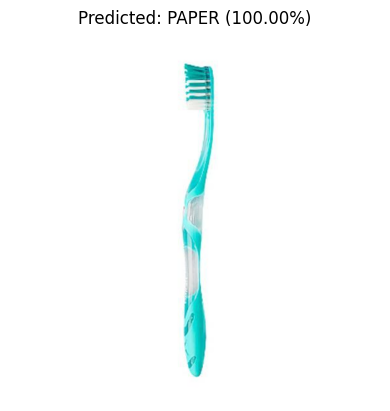

In [ ]:
# # Observe the upload widget for changes
# upload_widget.observe(on_upload_change, names='value')

# # Display the upload widget
# display(upload_widget)